
# LO Drell–Yan: differential distribution in invariant mass

This notebook computes the **leading-order (LO)** Drell–Yan spectrum

$$
pp \to \ell^+\ell^- + X
\qquad\Rightarrow\qquad
\frac{d\sigma}{dM}
$$

as a function of the dilepton invariant mass $M$, using **LHAPDF** PDFs and a **rapidity integral** at fixed $M$.

**Physics assumptions (LO):**
- Incoming hadrons: protons (use any PDF set in LHAPDF)
- Partonic channel: $q\bar q \to \ell^+\ell^-$ (no QCD radiation)
- Factorisation/renormalisation scale: $\mu_F^2=\mu_R^2=M^2$ (editable)
- Inclusive over dilepton angles

You can switch between:
- `"photon"`: pure-$\gamma$ term
- `"gammaZ"`: $\gamma/Z$ including interference


In [24]:

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad
import lhapdf


plt.rcParams.update({
    "text.usetex": True,           # Use LaTeX for all text
    "font.family": "serif",        # Use a specific font family
    "text.latex.preamble": r"\usepackage{amsmath, amssymb, bm}",  # Load additional packages
})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 16



## Configuration


In [25]:

# --- Collider / PDF configuration ---
sqrt_s = 14_000.0  # GeV (LHC-like default). Change freely.
s = sqrt_s**2

#pdf_set_name = "PDF4LHC21_40"
pdf_set_name = "PDF4EFT_baseline_noHMDY_100"
pset = lhapdf.getPDFSet(pdf_set_name)
pdfs = pset.mkPDFs()

replica = 0  # 0=central, 1..N-1 = members
pdf = pdfs[replica]

# --- Numerical integration controls ---
# quad absolute/relative tolerances (tune if needed)
epsabs = 0.0
epsrel = 1e-4

# Factorisation scale choice: muF^2 = M^2 by default
def muF2(M):
    return M**2


LHAPDF 6.5.4 loading all 101 PDFs in set PDF4EFT_baseline_noHMDY_100
PDF4EFT_baseline_noHMDY_100, version 1; 101 PDF members



## Electroweak inputs and LO partonic cross section

We use the LO inclusive partonic cross section for $q\bar q \to \ell^+\ell^-$, integrated over angles:

$$
\hat\sigma(\hat s) \;=\; \frac{4\pi\alpha^2}{3 N_c \hat s}\,
\left[ Q_q^2 Q_\ell^2 \;+\; 2 Q_q Q_\ell\, v_q v_\ell\, \chi_1(\hat s)\;+\; (v_q^2+a_q^2)(v_\ell^2+a_\ell^2)\,\chi_2(\hat s)\right]
$$

with standard $\chi_{1,2}$ propagator factors. Units returned in pb.


In [26]:

# --- Units ---
GeV2_to_pb = 0.389379e9  # 1 GeV^-2 = 0.389379 mb = 0.389379e9 pb

# --- EW parameters (reasonable defaults; adjust if desired) ---
alpha_em = 1/127.95
sW2 = 0.23129
cW2 = 1.0 - sW2

mZ = 91.1876   # GeV
gZ = 2.4952    # GeV

Nc = 3.0

def v_a_couplings(Q, T3, sW2=sW2):
    # v = T3 - 2 Q sW^2, a = T3
    v = T3 - 2.0 * Q * sW2
    a = T3
    return v, a

# Charged lepton: Q=-1, T3=-1/2
Q_l, T3_l = -1.0, -0.5
v_l, a_l = v_a_couplings(Q_l, T3_l)

# Quark charges and isospins
quarks = {
    "u": {"pdg":  2, "Q":  2/3, "T3": +0.5},
    "d": {"pdg":  1, "Q": -1/3, "T3": -0.5},
    "s": {"pdg":  3, "Q": -1/3, "T3": -0.5},
    "c": {"pdg":  4, "Q":  2/3, "T3": +0.5},
    "b": {"pdg":  5, "Q": -1/3, "T3": -0.5},
}

def chi_factors(shat):
    # dimensionless chi1, chi2
    denom = (shat - mZ**2)**2 + (mZ * gZ)**2
    chi1 = (shat * (shat - mZ**2) / denom) * (1.0 / (4.0 * sW2 * cW2))
    chi2 = (shat**2 / denom) * (1.0 / (16.0 * (sW2**2) * (cW2**2)))
    return chi1, chi2

def sigmahat_qqbar_to_ll(shat, quark_name, mode="gammaZ"):
    # Returns inclusive partonic cross section in pb at shat=M^2
    qinfo = quarks[quark_name]
    Q_q, T3_q = qinfo["Q"], qinfo["T3"]
    v_q, a_q = v_a_couplings(Q_q, T3_q)

    pref = (4.0 * np.pi * alpha_em**2) / (3.0 * Nc * shat)  # GeV^-2

    if mode == "photon":
        bracket = (Q_q**2) * (Q_l**2)
    elif mode == "gammaZ":
        chi1, chi2 = chi_factors(shat)
        bracket = (Q_q**2)*(Q_l**2) + 2.0*(Q_q*Q_l)*(v_q*v_l)*chi1 + ((v_q**2+a_q**2)*(v_l**2+a_l**2))*chi2
    else:
        raise ValueError("mode must be 'photon' or 'gammaZ'")

    return pref * bracket * GeV2_to_pb



## LO rapidity integral

At fixed $M$ and rapidity $y$:

$$
x_1 = \frac{M}{\sqrt{s}} e^{y},\qquad x_2 = \frac{M}{\sqrt{s}} e^{-y},\qquad \hat s = M^2,
$$

and $y_{\max}=\ln(\sqrt{s}/M)$. Then:

$$
\frac{d\sigma}{dM} = \frac{2M}{s}\int_{-y_{\max}}^{y_{\max}} dy\;
\sum_q \left[f_q(x_1,\mu_F^2) f_{\bar q}(x_2,\mu_F^2) + f_{\bar q}(x_1,\mu_F^2) f_q(x_2,\mu_F^2)\right]\,
\hat\sigma_{q\bar q}(M^2).
$$


In [27]:

def x1x2_from_My(M, y, sqrt_s=sqrt_s):
    tau = M / sqrt_s
    return tau * np.exp(y), tau * np.exp(-y)

def fq(pdf, pdg, x, Q2):
    # LHAPDF returns x*f(x,Q2); convert to f(x,Q2)
    if x <= 0.0 or x >= 1.0:
        return 0.0
    return pdf.xfxQ2(pdg, x, Q2) / x

def dy_integrand(y, M, pdf, mode="gammaZ"):
    Q2 = muF2(M)
    x1, x2 = x1x2_from_My(M, y)
    if (x1 <= 0.0) or (x1 >= 1.0) or (x2 <= 0.0) or (x2 >= 1.0):
        return 0.0

    shat = M**2

    total = 0.0
    for qname, qinfo in quarks.items():
        pdg = qinfo["pdg"]
        f_q_x1  = fq(pdf,  pdg, x1, Q2)
        f_qb_x1 = fq(pdf, -pdg, x1, Q2)
        f_q_x2  = fq(pdf,  pdg, x2, Q2)
        f_qb_x2 = fq(pdf, -pdg, x2, Q2)

        lum = f_q_x1 * f_qb_x2 + f_qb_x1 * f_q_x2
        total += lum * sigmahat_qqbar_to_ll(shat, qname, mode=mode)
    return total

def dsigma_dM(M, pdf, mode="gammaZ", epsabs=epsabs, epsrel=epsrel, limit=200):
    # Returns (value, estimated integration error) in pb/GeV
    if M <= 0.0 or M >= sqrt_s:
        return 0.0, 0.0

    ymax = np.log(sqrt_s / M)

    val, err = quad(
        lambda y: dy_integrand(y, M, pdf, mode=mode),
        -ymax, ymax,
        epsabs=epsabs, epsrel=epsrel, limit=limit
    )

    pref = (2.0 * M) / s
    return pref * val, pref * err



## Compute and plot a spectrum


In [28]:

# --- Mass grid (edit as you like) ---
M_min, M_max = 20.0, 1000.0
nM = 25
M_grid = np.logspace(np.log10(M_min), np.log10(M_max), nM)

mode = "gammaZ"  # "photon" or "gammaZ"

dsig = []
dsig_err = []

for M in M_grid:
    val, err = dsigma_dM(M, pdf, mode=mode)
    dsig.append(val)
    dsig_err.append(err)

dsig = np.array(dsig)
dsig_err = np.array(dsig_err)

dsig[:5], dsig_err[:5]


(array([144.04515851,  83.26250154,  47.68919534,  27.12076349,
         15.38246234]),
 array([0.00750097, 0.00782965, 0.00423728, 0.00039584, 0.00129941]))

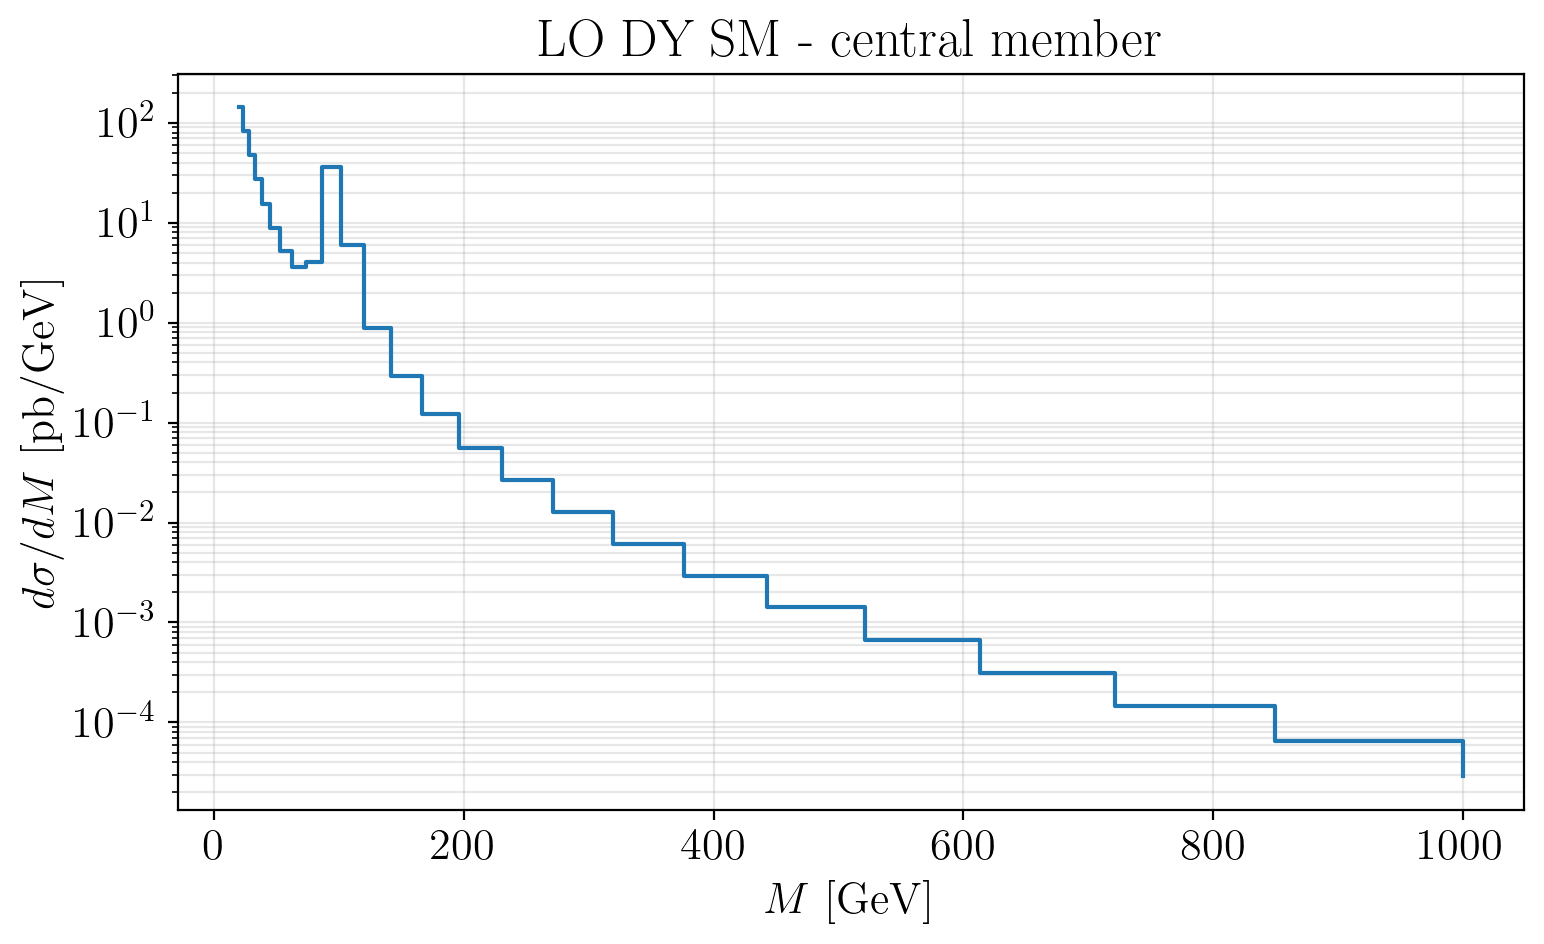

In [29]:
fig, ax = plt.subplots(figsize=(8,5))

#ax.errorbar(M_grid, dsig, yerr=dsig_err, fmt="o", capsize=2)
# plot as histogram-like steps (use the precomputed x_step/y_step arrays)
ax.step(M_grid, dsig, where="post", lw=1.5, label=r"$d\sigma/dM$ (steps)")


ax.set_yscale("log")
ax.set_xlabel(r"$M$ [GeV]")
ax.set_ylabel(r"$d\sigma/dM$ [pb/GeV]")
#ax.set_title(f"LO DY ({mode}) | sqrt(s)={sqrt_s:g} GeV | {pdf_set_name} member {replica}")
ax.set_title(f"LO DY SM - central member")
ax.grid(True, which="both", alpha=0.3)
fig.tight_layout()
plt.show()


In [31]:
# Cross check
# Integrate dσ/dM and get the total cross section
def integrate_dsigma_dM(M_grid, dsig):
    return np.trapz(dsig, M_grid)

total_dsig = integrate_dsigma_dM(M_grid, dsig)

print(f"Total cross section: {total_dsig:.2f} pb")

Total cross section: 1871.83 pb


In [22]:
# Compute dσ/dM for multiple PDF sets (keeps existing `dsig` intact).
# Includes the requested "_80" set in addition to the existing "_100" set.
pdf_set_names = [
    "PDF4EFT_baseline_noHMDY_100",
    "PDF4EFT_baseline_noHMDY_40",
]

nM = len(M_grid)
results = {}

for pdf_set_name_local in pdf_set_names:
    pset_local = lhapdf.getPDFSet(pdf_set_name_local)
    pdfs_local = pset_local.mkPDFs()
    n_members_local = len(pdfs_local)

    all_vals_local = np.zeros((n_members_local, nM))
    all_errs_local = np.zeros((n_members_local, nM))

    for i, pdf_m in enumerate(pdfs_local):
        for j, Mval in enumerate(M_grid):
            v, e = dsigma_dM(Mval, pdf_m, mode=mode, epsrel=epsrel)
            all_vals_local[i, j] = v
            all_errs_local[i, j] = e
        # progress (overwrites same line)
        print(f"{pdf_set_name_local}: member {i+1}/{n_members_local} done", end="\r")

    print(f"\n{pdf_set_name_local}: computed dσ/dM for {n_members_local} members; arrays shapes = {all_vals_local.shape}, {all_errs_local.shape}")
    results[pdf_set_name_local] = {
        "pset": pset_local,
        "pdfs": pdfs_local,
        "all_vals": all_vals_local,
        "all_errs": all_errs_local,
    }

# Example access:
# results["PDF4EFT_baseline_noHMDY_100"]["all_vals"]  # array shape (n_members, nM)


LHAPDF 6.5.4 loading all 101 PDFs in set PDF4EFT_baseline_noHMDY_100
PDF4EFT_baseline_noHMDY_100, version 1; 101 PDF members
PDF4EFT_baseline_noHMDY_100: member 101/101 done
PDF4EFT_baseline_noHMDY_100: computed dσ/dM for 101 members; arrays shapes = (101, 25), (101, 25)
LHAPDF 6.5.4 loading all 41 PDFs in set PDF4EFT_baseline_noHMDY_40
PDF4EFT_baseline_noHMDY_40, version 1; 41 PDF members
PDF4EFT_baseline_noHMDY_40: member 41/41 done
PDF4EFT_baseline_noHMDY_40: computed dσ/dM for 41 members; arrays shapes = (41, 25), (41, 25)


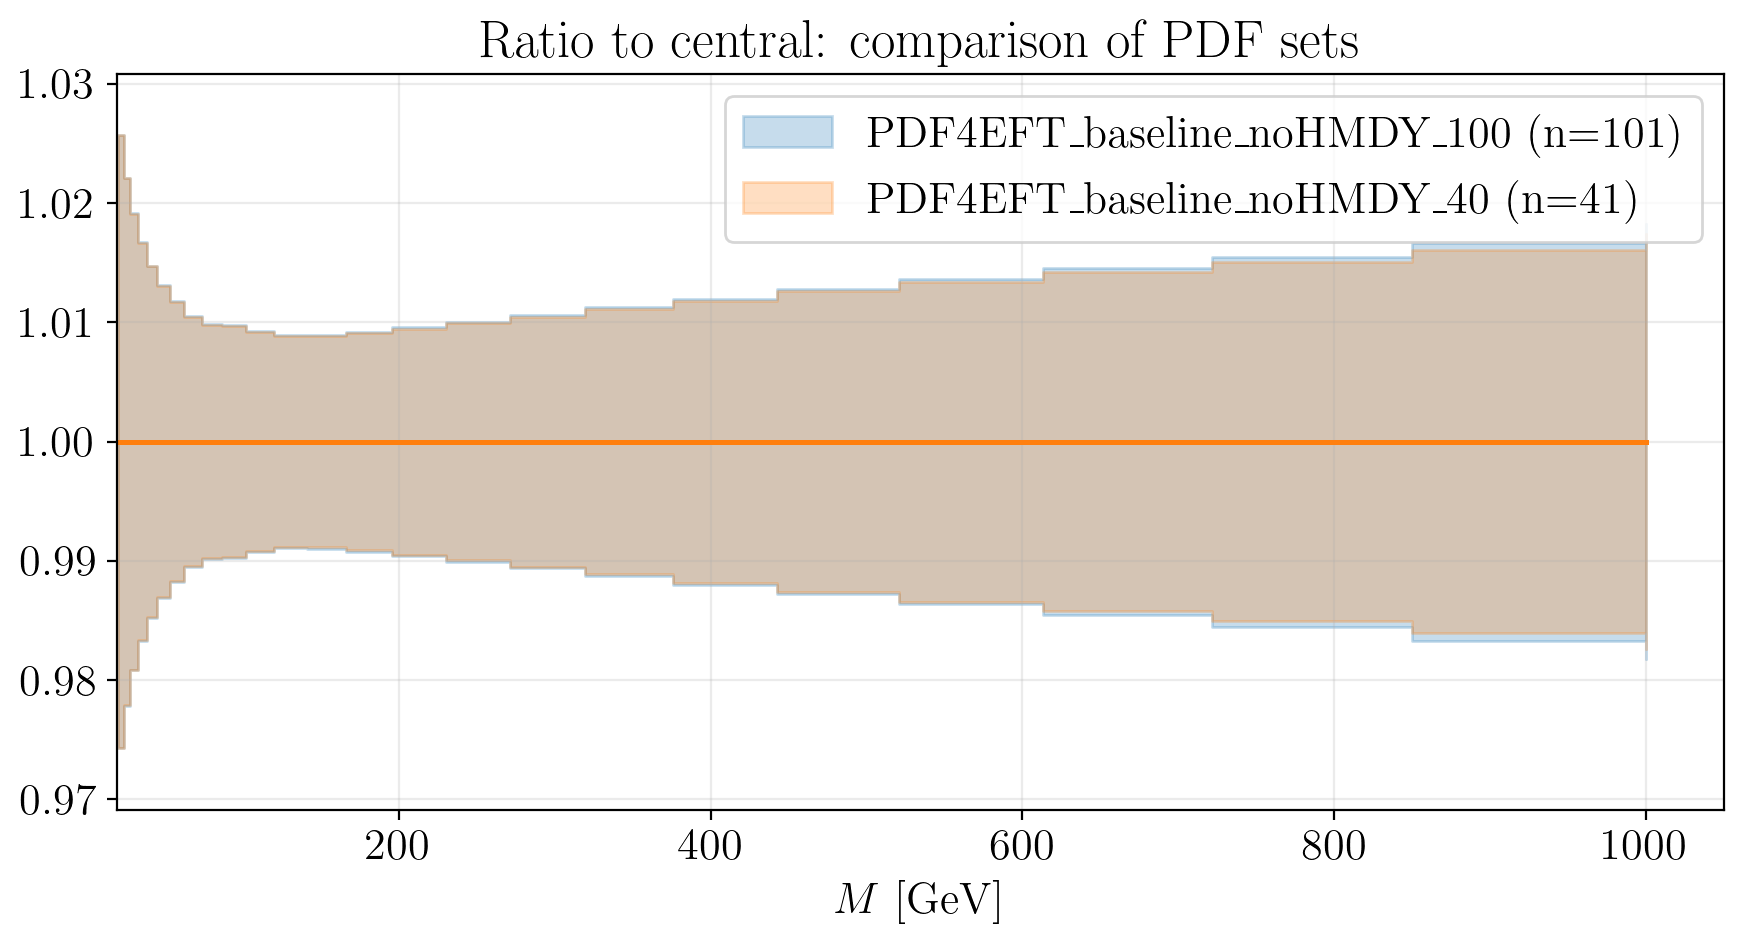

In [23]:
# Ratio-to-central comparison for multiple PDF sets (overlay uncertainty bands)
# Uses existing `results` and `M_grid` in the notebook.

plt.figure(figsize=(9,5))
ax = plt.gca()

colors = ["C0", "C1", "C2", "C3"]
all_maxdevs = []

plot_handles = []

for idx, pdf_set_name_local in enumerate(pdf_set_names):
    data = results[pdf_set_name_local]["all_vals"]   # shape (n_members, nM)
    n_members_local = data.shape[0]
    central_local = data[0]                          # member 0 as central

    # avoid division by zero: mask zero central bins
    mask_pos = central_local > 0.0
    ratios = np.full_like(data, np.nan)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios[:, mask_pos] = data[:, mask_pos] / central_local[mask_pos]

    # PDF uncertainty band: sqrt(sum (member - central)^2)
    delta_local = np.sqrt(np.sum((data - central_local[np.newaxis, :])**2, axis=0))
    band_low = np.full_like(central_local, np.nan)
    band_high = np.full_like(central_local, np.nan)
    band_low[mask_pos]  = (central_local - delta_local)[mask_pos] / central_local[mask_pos]
    band_high[mask_pos] = (central_local + delta_local)[mask_pos] / central_local[mask_pos]

    # compute deviations for sensible y-limits
    dev_members = np.nanmax(np.abs(ratios - 1.0))
    dev_band = max(np.nanmax(np.abs(band_low - 1.0)), np.nanmax(np.abs(band_high - 1.0)))
    all_maxdevs.append(max(dev_members, dev_band))

    color = colors[idx % len(colors)]
    # uncertainty band
    h = ax.fill_between(M_grid, band_low, band_high, step='post', color=color, alpha=0.25,
                        label=f"{pdf_set_name_local} (n={n_members_local})")
    plot_handles.append(h)
    # optionally show central (will be at 1 by definition)
    ax.plot(M_grid, np.ones_like(M_grid), color=color, lw=1.8)

# global y-limits
maxdev = max(all_maxdevs) if all_maxdevs else 0.05
y_margin = max(0.02, maxdev * 1.2)
ymin = max(0.0, 1.0 - y_margin)
ymax = 1.0 + y_margin

#ax.set_xscale("log")
ax.set_xlim(M_grid[0]*0.95, M_grid[-1]*1.05)
ax.set_ylim(ymin, ymax)

ax.set_xlabel(r"$M$ [GeV]")
ax.set_title("Ratio to central: comparison of PDF sets")
ax.grid(True, which="both", alpha=0.25)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Old files

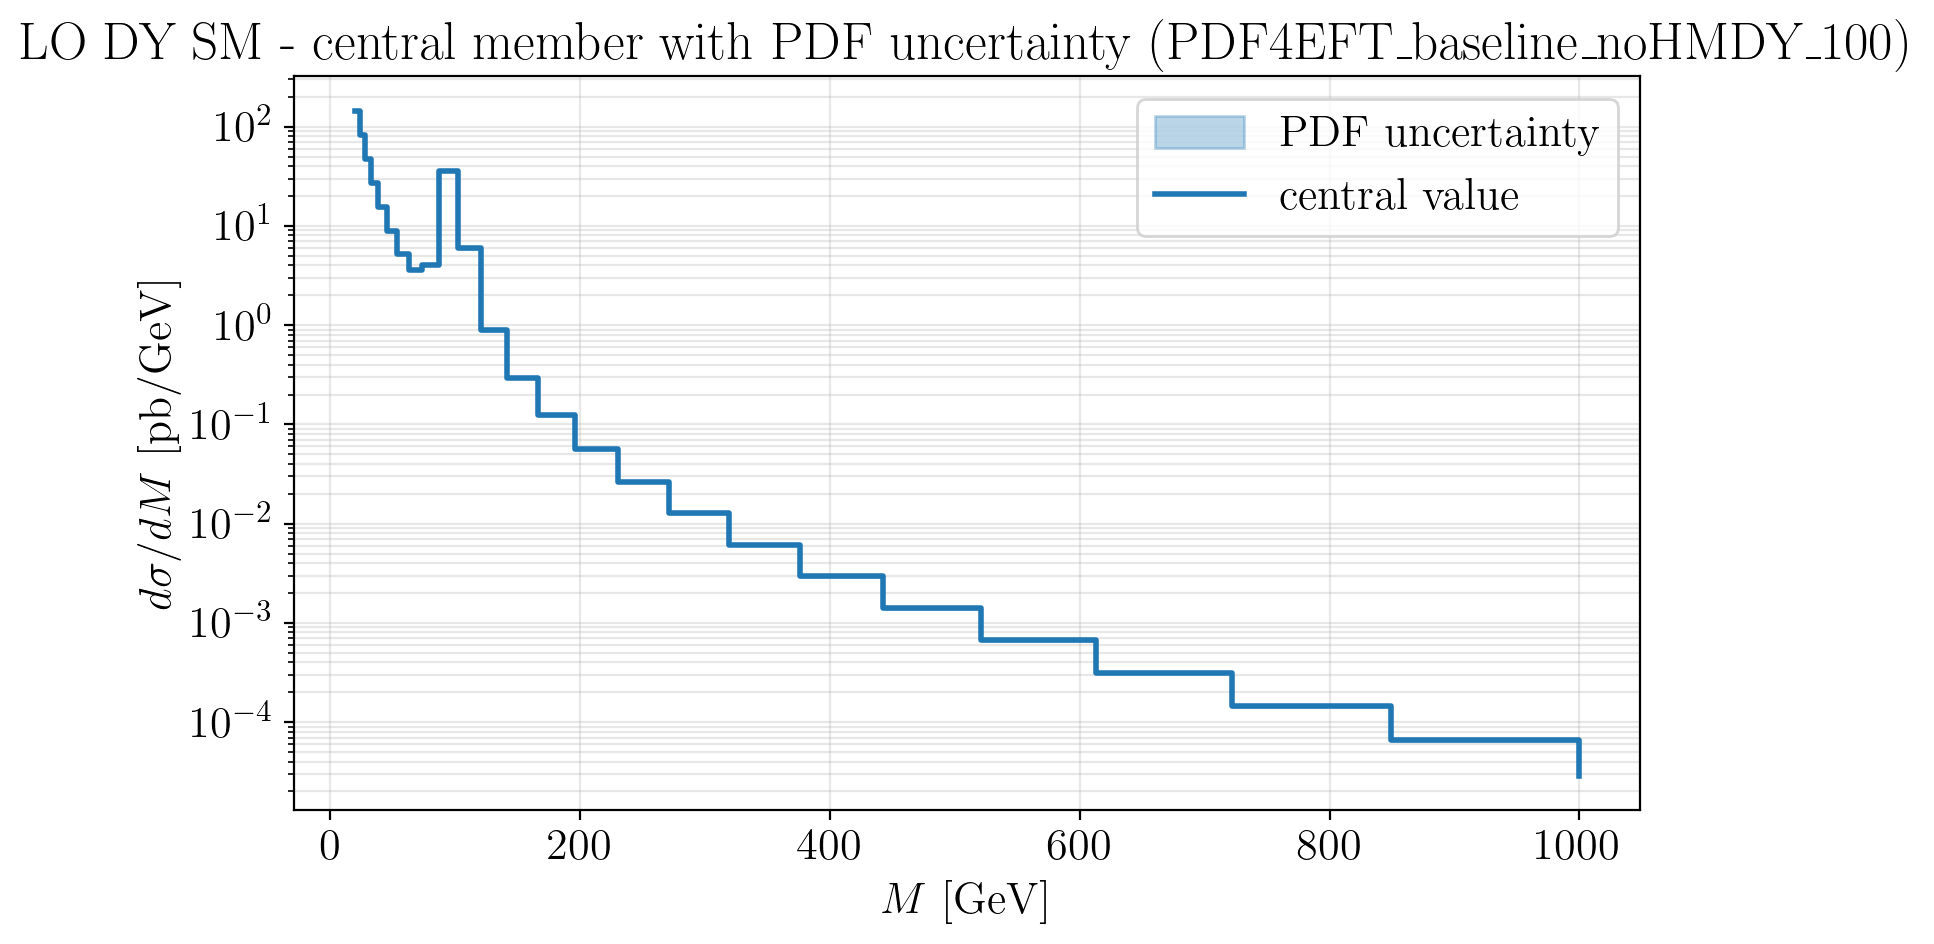

In [8]:
# compute PDF uncertainty band: sqrt(sum_members (f_member - f_central)^2)
central = all_vals[0]                       # shape (nM,)
delta = np.sqrt(np.sum((all_vals - central[np.newaxis, :])**2, axis=0))

y_low = central - delta
y_high = central + delta

# avoid non-positive values for log scale plotting
y_low_plot = np.maximum(y_low, 1e-30)

fig, ax = plt.subplots(figsize=(8,5))

ax.fill_between(M_grid, y_low_plot, y_high, step='post', alpha=0.3, color='C0',
                label=r'PDF uncertainty')
ax.step(M_grid, central, where='post', lw=2, color='C0', label='central value')

ax.set_yscale("log")
ax.set_xlabel(r"$M$ [GeV]")
ax.set_ylabel(r"$d\sigma/dM$ [pb/GeV]")
ax.set_title(f"LO DY SM - central member with PDF uncertainty ({pdf_set_name})")
ax.grid(True, which="both", alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

In [9]:
np.all(y_high - central > 0)

True

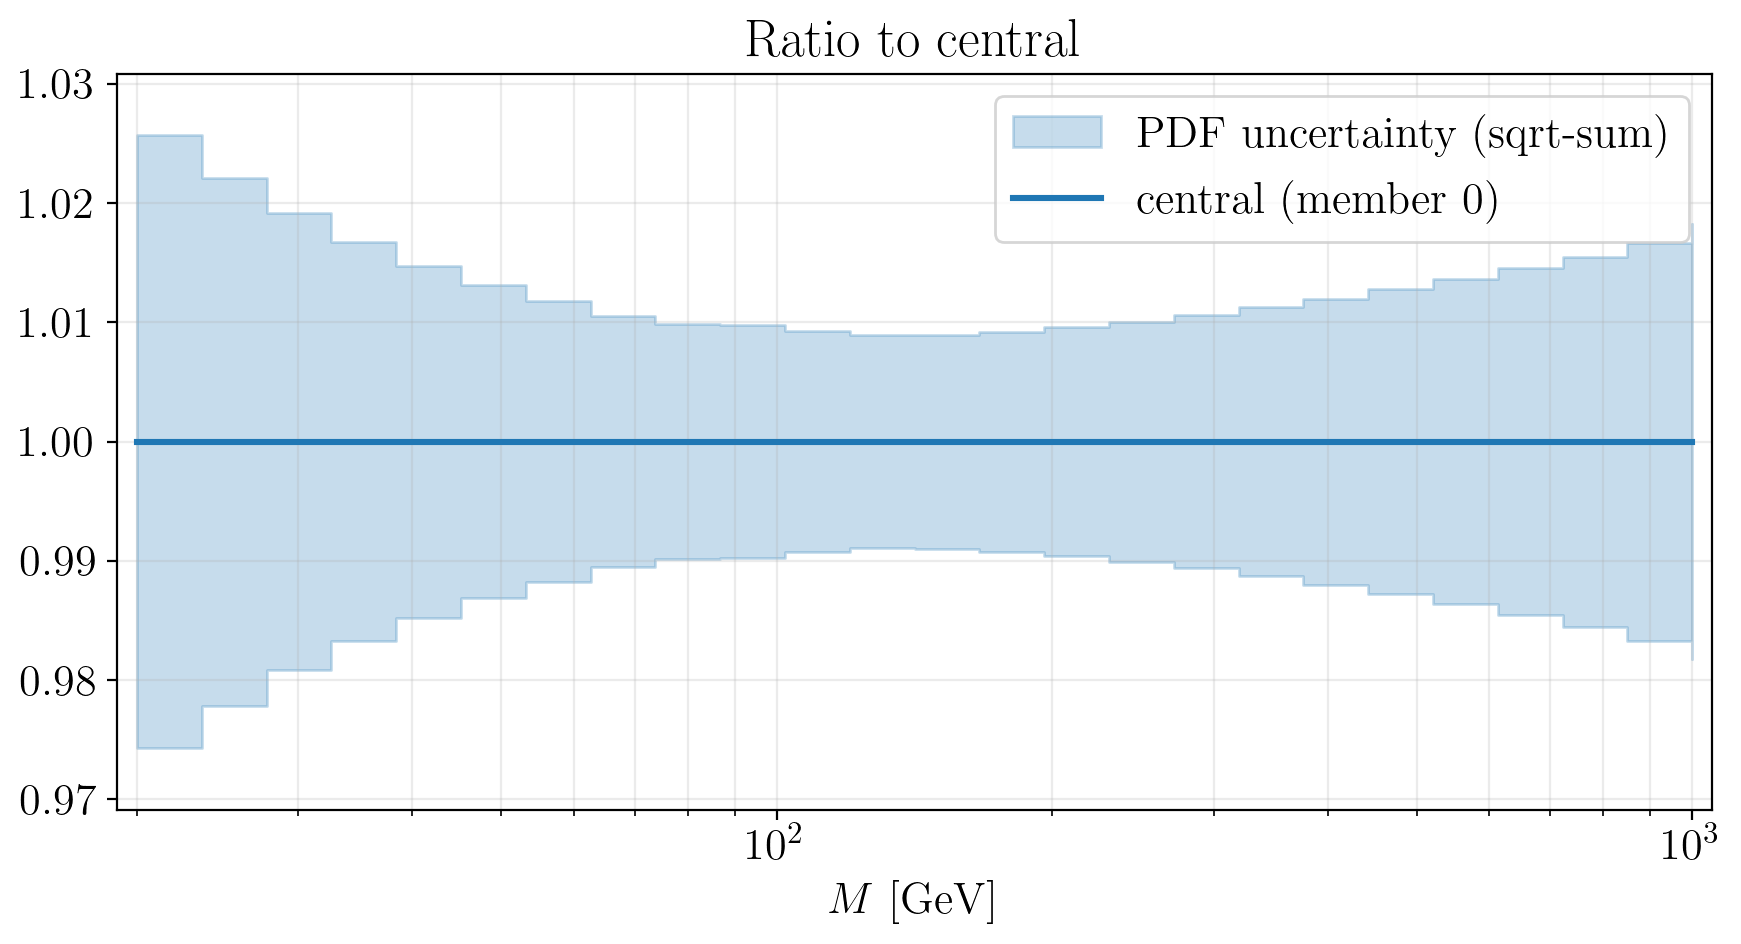

In [10]:
# improved ratio plot vs central (uses existing arrays: all_vals, central, delta, M_grid)
ratios = all_vals / central[np.newaxis, :]     # shape (n_members, nM)

# PDF uncertainty band in ratio units
band_low = (central - delta) / central
band_high = (central + delta) / central

# dynamic y-limits: based on members + band, with a small floor
dev_members = np.max(np.abs(ratios - 1.0))
dev_band = max(np.max(np.abs(band_low - 1.0)), np.max(np.abs(band_high - 1.0)))
maxdev = max(dev_members, dev_band)
y_margin = max(0.02, maxdev * 1.2)   # at least 2% margin

ymin = max(0.0, 1.0 - y_margin)
ymax = 1.0 + y_margin

fig, ax = plt.subplots(figsize=(9,5))

# PDF band
ax.fill_between(M_grid, band_low, band_high, step='post', color='C0', alpha=0.25,
                label='PDF uncertainty (sqrt-sum)')

## all members as thin, semi-transparent lines
#for i in range(len(ratios)):
    #ax.plot(M_grid, ratios[i], color='gray', alpha=0.35, lw=0.8)

# central line (should be exactly 1)
ax.plot(M_grid, np.ones_like(M_grid), color='C0', lw=2.2, label='central (member 0)')

ax.set_xscale('log')
ax.set_xlim(M_grid[0]*0.95, M_grid[-1]*1.05)
ax.set_ylim(ymin, ymax)

#ax.axhline(1.0, color='k', ls='--', lw=1)
ax.set_xlabel(r"$M$ [GeV]")
#ax.set_ylabel("Ratio to central")
ax.set_title(f"Ratio to central")
ax.grid(True, which='both', alpha=0.25)
ax.legend(loc='upper right')

fig.tight_layout()
plt.show()

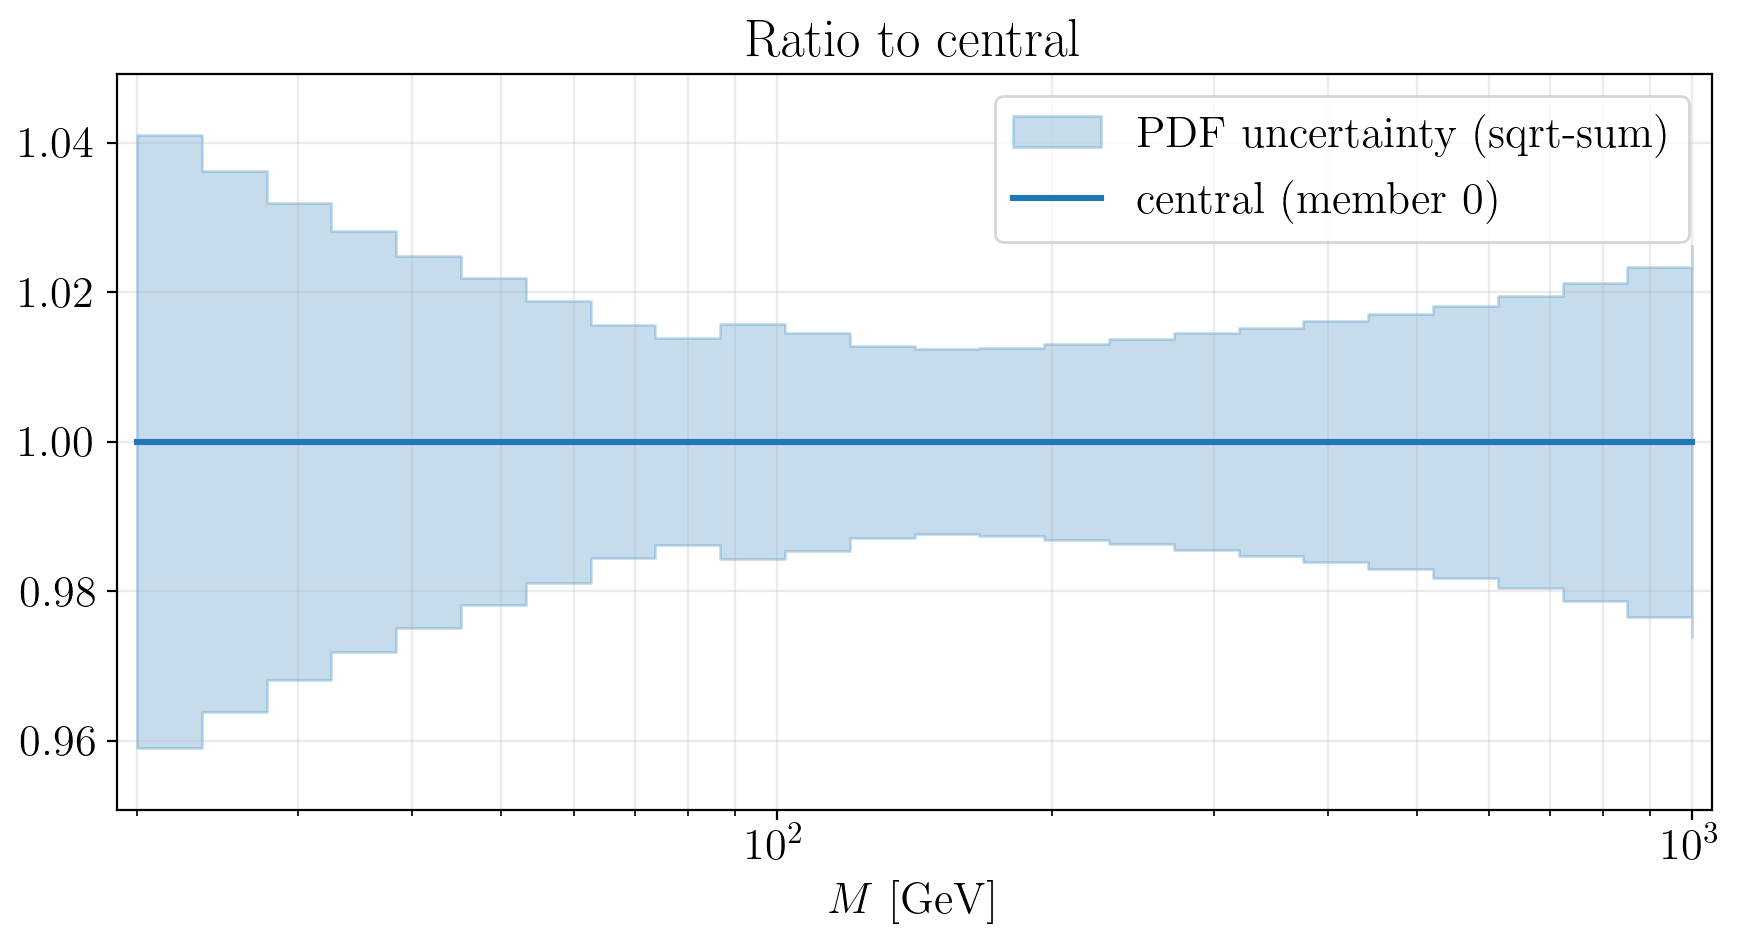

In [49]:
# improved ratio plot vs central (uses existing arrays: all_vals, central, delta, M_grid)
ratios = all_vals / central[np.newaxis, :]     # shape (n_members, nM)

# PDF uncertainty band in ratio units
band_low = (central - delta) / central
band_high = (central + delta) / central

# dynamic y-limits: based on members + band, with a small floor
dev_members = np.max(np.abs(ratios - 1.0))
dev_band = max(np.max(np.abs(band_low - 1.0)), np.max(np.abs(band_high - 1.0)))
maxdev = max(dev_members, dev_band)
y_margin = max(0.02, maxdev * 1.2)   # at least 2% margin

ymin = max(0.0, 1.0 - y_margin)
ymax = 1.0 + y_margin

fig, ax = plt.subplots(figsize=(9,5))

# PDF band
ax.fill_between(M_grid, band_low, band_high, step='post', color='C0', alpha=0.25,
                label='PDF uncertainty (sqrt-sum)')

## all members as thin, semi-transparent lines
#for i in range(len(ratios)):
    #ax.plot(M_grid, ratios[i], color='gray', alpha=0.35, lw=0.8)

# central line (should be exactly 1)
ax.plot(M_grid, np.ones_like(M_grid), color='C0', lw=2.2, label='central (member 0)')

ax.set_xscale('log')
ax.set_xlim(M_grid[0]*0.95, M_grid[-1]*1.05)
ax.set_ylim(ymin, ymax)

#ax.axhline(1.0, color='k', ls='--', lw=1)
ax.set_xlabel(r"$M$ [GeV]")
#ax.set_ylabel("Ratio to central")
ax.set_title(f"Ratio to central")
ax.grid(True, which='both', alpha=0.25)
ax.legend(loc='upper right')

fig.tight_layout()
plt.show()


## Quick PDF member comparison (optional)

This repeats the spectrum for a few PDF members. For speed, consider loosening `epsrel` or reducing `nM`.


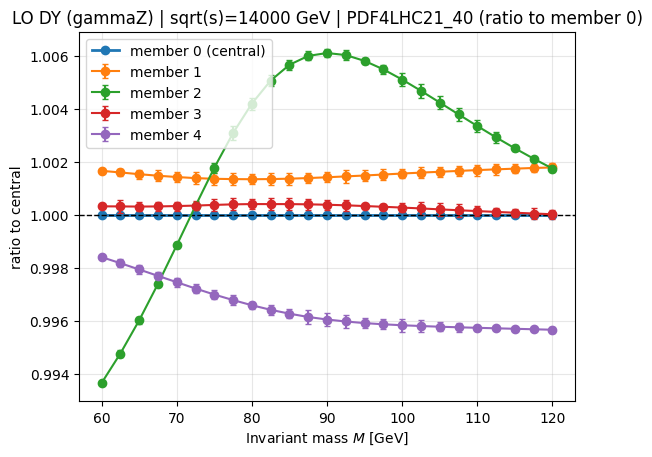

In [8]:

members_to_compare = [0, 1, 2, 3, 4]  # must be < len(pdfs)
mode = "gammaZ"

curves = {}
for m in members_to_compare:
    pdf_m = pdfs[m]
    vals = []
    errs = []
    for M in M_grid:
        v, e = dsigma_dM(M, pdf_m, mode=mode, epsrel=2e-4)  # slightly looser for speed
        vals.append(v); errs.append(e)
    curves[m] = (np.array(vals), np.array(errs))

plt.figure()
central_vals, central_errs = curves[0]

for m, (vals, errs) in curves.items():
    # compute ratio to central and propagate errors (assuming independent)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = vals / central_vals
        rel_err = np.zeros_like(vals)
        rel_err_c = np.zeros_like(central_vals)
        mask_vals = vals > 0
        mask_c = central_vals > 0
        rel_err[mask_vals] = errs[mask_vals] / vals[mask_vals]
        rel_err_c[mask_c] = central_errs[mask_c] / central_vals[mask_c]
        ratio_err = ratio * np.sqrt(rel_err**2 + rel_err_c**2)

    if m == 0:
        # plot central as a thicker line (no error bars needed)
        plt.plot(M_grid, ratio, marker="o", linestyle="-", lw=2, label=f"member {m} (central)")
    else:
        plt.errorbar(M_grid, ratio, yerr=ratio_err, marker="o", linestyle="-", capsize=2, label=f"member {m}")

plt.axhline(1.0, color="k", linestyle="--", linewidth=1)
plt.xlabel(r"Invariant mass $M$ [GeV]")
plt.ylabel("ratio to central")
plt.title(f"LO DY ({mode}) | sqrt(s)={sqrt_s:g} GeV | {pdf_set_name} (ratio to member 0)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()



## Notes / extensions

- Add **binning** and save tables (CSV/Parquet).
- Add a simple **QCD K-factor** as a multiplicative correction.
- Add **acceptance cuts** by keeping the angular dependence (go beyond inclusive LO).
- For very high \(M\), you may want to tighten `epsrel` and/or increase `limit`.
